# MNIST Digit Detector

In [1]:
# Imports

import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim

import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets

In [2]:
# Device configuration
# Use the Apple M1 GPU
device = torch.device("mps")
device

device(type='mps')

In [10]:
# Dataset Import
mnist_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

mnist_train = datasets.MNIST(root='./data',
                             train=True,
                             transform=mnist_transform,
                             download=True)
mnist_test = datasets.MNIST(root='./data',
                            train=False,
                            transform=mnist_transform,
                            download=True)

# Data Loader
train_loader = torch.utils.data.DataLoader(dataset=mnist_train,
                                           batch_size=100,
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=mnist_test,
                                            batch_size=100,
                                            shuffle=False)

print("Train dataset size: ", len(mnist_train))
print("Test dataset size: ", len(mnist_test))


Train dataset size:  60000
Test dataset size:  10000


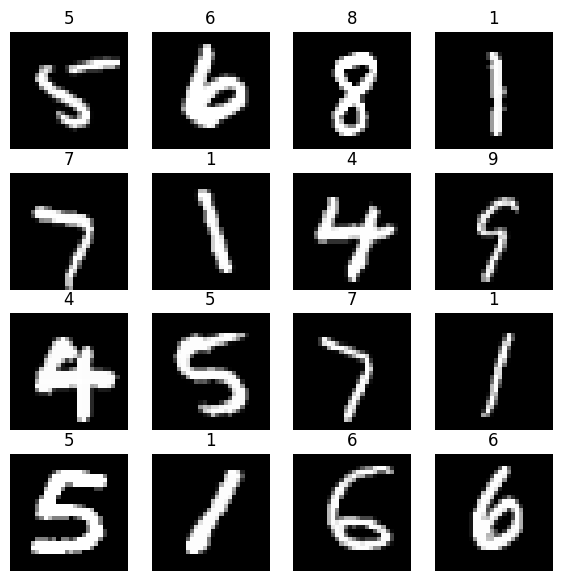

In [12]:
# Plotting
def plot_images(images, labels):
    plt.figure(figsize=(7, 7))
    for i in range(16):
        plt.subplot(4, 4, i+1)
        plt.imshow(images[i].reshape(28, 28), cmap='gray')
        plt.title(labels[i], y=1)
        plt.axis('off')
    plt.show()

# Plotting
images, labels = next(iter(train_loader))
plot_images(images.numpy(), labels.numpy())


In [6]:
# Digit Detector (based on LeNet (layers) / AlexNet (uses ReLU & Max-Pooling))

class DigitDetector(nn.Module):
    def __init__(self):
        super(DigitDetector, self).__init__()
        # shape: (28, 28)
        self.conv1 = nn.Sequential(
            nn.Conv2d(1, 6, kernel_size=5, stride=1, padding=2),
            # shape: (6, 28, 28)
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
            # shape: (6, 14, 14)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(6, 16, kernel_size=5, stride=1, padding=0),
            # shape: (16, 10, 10)
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
            # shape: (16, 5, 5)
        )

        self.flatten = nn.Flatten()
        # shape: (16*5*5)

        self.fcn1 = nn.Sequential(
            nn.Linear(16*5*5, 120),
            # shape: (120)
            nn.ReLU()
        )
        self.fcn2 = nn.Sequential(
            nn.Linear(120, 84),
            #`shape: (84)
            nn.ReLU()
        )
        self.output = nn.Linear(84, 10)
        # shape: (10)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # Convolutional Layer
        out = self.conv1(x)
        out = self.conv2(out)

        # Flatten
        out = self.flatten(out)

        # Fully Connected Layer
        out = self.fcn1(out)
        out = self.fcn2(out)
        out = self.output(out)

        return out

model = DigitDetector().to(device)
model

DigitDetector(
  (conv1): Sequential(
    (0): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fcn1): Sequential(
    (0): Linear(in_features=400, out_features=120, bias=True)
    (1): ReLU()
  )
  (fcn2): Sequential(
    (0): Linear(in_features=120, out_features=84, bias=True)
    (1): ReLU()
  )
  (output): Linear(in_features=84, out_features=10, bias=True)
)

In [7]:
# Loss and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training
total_step = len(train_loader)
num_epochs = 10

for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)

        # Forward Propagation
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward Propagation and Weight Update
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (i+1) % 100 == 0:
            print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'.format(epoch+1, num_epochs, i+1, total_step, loss.item()))

# Testing
model.eval()

with torch.no_grad():
    correct = 0
    total = 0
    failed_tests = []

    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        for j in range(len(labels)):
            if predicted[j] != labels[j]:
                failed_tests.append((images[j].cpu(), predicted[j].cpu(), labels[j].cpu()))

    print('Test Accuracy: {} %'.format(100 * correct / total))

Epoch [1/10], Step [100/600], Loss: 0.2658
Epoch [1/10], Step [200/600], Loss: 0.1137
Epoch [1/10], Step [300/600], Loss: 0.1964
Epoch [1/10], Step [400/600], Loss: 0.1630
Epoch [1/10], Step [500/600], Loss: 0.0938
Epoch [1/10], Step [600/600], Loss: 0.0547
Epoch [2/10], Step [100/600], Loss: 0.0535
Epoch [2/10], Step [200/600], Loss: 0.0104
Epoch [2/10], Step [300/600], Loss: 0.0594
Epoch [2/10], Step [400/600], Loss: 0.0135
Epoch [2/10], Step [500/600], Loss: 0.0516
Epoch [2/10], Step [600/600], Loss: 0.0115
Epoch [3/10], Step [100/600], Loss: 0.0336
Epoch [3/10], Step [200/600], Loss: 0.0944
Epoch [3/10], Step [300/600], Loss: 0.0100
Epoch [3/10], Step [400/600], Loss: 0.0982
Epoch [3/10], Step [500/600], Loss: 0.0464
Epoch [3/10], Step [600/600], Loss: 0.0448
Epoch [4/10], Step [100/600], Loss: 0.0103
Epoch [4/10], Step [200/600], Loss: 0.0096
Epoch [4/10], Step [300/600], Loss: 0.0228
Epoch [4/10], Step [400/600], Loss: 0.0190
Epoch [4/10], Step [500/600], Loss: 0.0540
Epoch [4/10

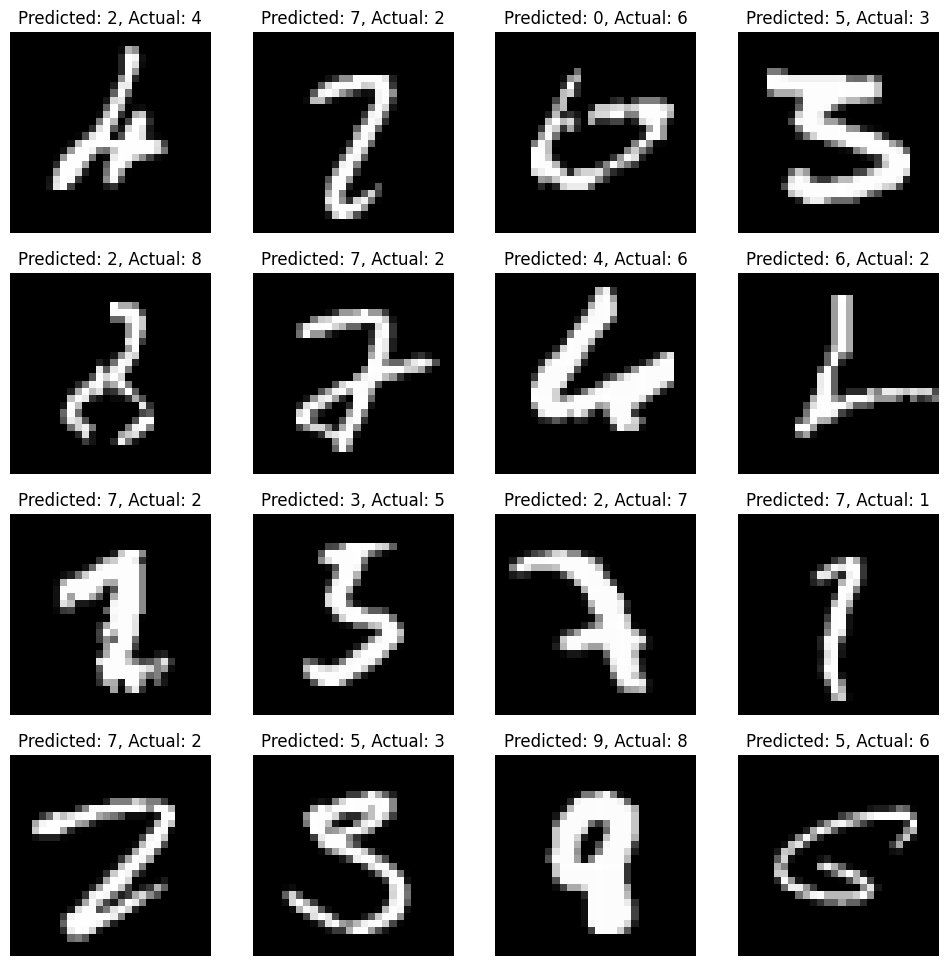

In [8]:
# Plot Failed Cases
def plot_failed_tests(failed_tests, num_tests=16):
    plt.figure(figsize=(12, 12))
    for i in range(num_tests):
        if i >= len(failed_tests):
            break
        image, predicted, actual = failed_tests[i]
        plt.subplot(4, 4, i+1)
        plt.imshow(image.numpy().reshape(28, 28), cmap='gray')
        plt.title('Predicted: {}, Actual: {}'.format(predicted.item(), actual.item()))
        plt.axis('off')
    plt.show()

plot_failed_tests(failed_tests)